<a href="https://colab.research.google.com/github/Dayeon-Merry/Homework/blob/master/230701_%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 워드 임베딩 방법론 GloVe
* 다음의 두가지 방법론의 단점을 보완한 방법론임
  - LSAA(Latent Semantic Analysis) 방법론이 단어의 빈도수를 기반으로  코퍼스의 전체적인 통계 정보를 고려하지만, 단어 의미의 유추 작업에서 성능이 떨어져, 단어간의 관계성 부분을 고려하지 못함
  - Word2Vec은 window크기 내에서 주변 단어를 고려하기 때문에 단어 간 유추 작업은 뛰어나지만, 코퍼스의 전체적인 통계 정보를 반영하지 못함

  참고 사이트: https://wikidocs.net/22885

### 1-1. GloVe의 핵심 목표
  - 임베딩된 단어벡터 간 유사도 측정을 수월하게 하면서도 말뭉치 전체의 통계 정보를 잘 반영하는 것
  - 임베딩 된 중심 단어와 주변 단어 벡터의 내적이 전체 코퍼스에서의 동시 등장 확률이 되도록 만드는 것


### 1-2. Glove의 핵심 개념
* 동시 발생 행렬:
 - 중심단어 i의 주변으로 window size내에서 주변 단어 k가 등장한 횟수를 i행 k열에 기재한 행렬을 대칭으로 만들어줌
 - 예시) I like deep learning / I like NLP / I enjoy flying

|카운트| I |like|enjoy|deep|learning|NLP|flying|
| --- |---|---|---|---|---|---|---|
|  I  |0|2|1|0|0|0|0|
| like |2|0|0|1|0|1|0|
| enjoy |1|0|0|0|0|0|1|
| deep |0|1|0|0|1|0|0|
|learning |0|0|0|1|0|0|0|
|NLP |0|1|0|0|0|0|0|
|flying |0|0|1|0|0|0|0|

* 동시 등장 확률:
  - 특정 단어 i가 등장했을 때 어떤 단어 k가 등장한 횟수를 카운트하여 계산한 조건부 확률
  -  중심 단어 i의 행의 모든 값을 더한 값을 분모로 하고 i행 k열의 값을 분자로 한 값
  - 예시)

| P(k∣i) |k=solid|k=gas|k=water|k=fasion|
| --- |---|---|---|---|
|P(k∣ice)|0.00019|0.000066|0.003|0.000017|
|P(k∣steam)|0.000022|0.00078|0.0022|0.000018|
|P(k∣ice)/P(k∣steam)|8.9|0.085|1.36|0.96|
 > ice가 등장했을 때 solid가 등장할 확률 0.00019은 steam이 등장했을 때 solid가 등장할 확률인 0.000022보다 약 8.9배 큼

 > gas는 ice보다는 steam과 더 자주 등장하므로, P(gas l ice) / P(gas l steam)를 계산한 값은 1보다 훨씬 작은 값인 0.085가 나옴



### 1-3. GloVe 사용해보기

In [29]:
# !pip install glove-python-binary
# 설치가 안됩니다..

In [30]:
# from glove import Corpus, Glove

# corpus = Corpus()

# # 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
# corpus.fit(result, window=5)
# glove = Glove(no_components=100, learning_rate=0.05)

# # 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
# glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
# glove.add_dictionary(corpus.dictionary)

# 2. 한국어 도서 요약 데이터셋을 활용하여 한국어 워드 임베딩 구축

In [31]:
import pandas as pd
import numpy as np

In [32]:
f = open('/content/drive/MyDrive/Colab Notebooks/과제/230701_자연어처리/modi_output.txt', 'r')

In [33]:
data = f.read().splitlines()
print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [34]:
len(data)

160004

In [35]:
data[0]

'자신의 생각을 불명확하게 표현하는 사람들은 생각도 불명확할 가능성이 높다. 따라서 생각을 명료하게 정리하는 것이 명확한 글쓰기의 시작이다. 존 케네스 갈브레이드(John Kenneth Galbraith) 교수는 “아무리 복잡하고 어려운 주제라고 명쾌한 언어로 설명이 가능하다. 하지만 필자가 그 주제에 대해 완전히 이해하지 못하면 절대로 명확하게 쓸 수 없다.”고 했다. 명료한 글은 명료한 생각에서 나온다. 그렇지만 글을 고치다보면 생각도 명료하게 된다. 명료하게 쓰려면 내용을 단순화해야 한다. 많은 것을 전달하려는 욕심을 버리고 한두가지로 선택하고 거기 집중해야 한다. 앞에서 이야기한 간결성은 명확성에 도움이 된다. 명료함은 복잡한 설득기법을 사용하는 것보다 더 중요하다. 판사는 이해할 수 없는 사실관계 진술로는 설득되지 않는다. 설득기법이 명료함을 해치는 때에는 그 기법을 사용하지 않는다.\t주제가 아무리 복잡하고 어려울 지라도 필자가 주제에 대해 완벽하게 이해하고 있다면 명확한 글쓰기는 당연 가능하다. 명확한 글쓰기를 할 때 가장 중요한 점은 내용의 단순화 및 간결성이고 많은 것을 전달하려는 욕심을 버리는 것이다.'

In [36]:
words_df = pd.DataFrame({'book':data})
words_df

,book
0,자신의 생각을 불명확하게 표현하는 사람들은 생각도 불명확할 가능성이 높다. 따라서 ...
1,진로체험의 운영 역량을 강화하기 위하여 단위학교의 담당교사 외 에도 진로체험을 인솔...
2,"매우 최근 의견에서, Mary Footer는 이 논쟁을 한발 더 진전시켰다. 그녀는..."
3,에너지원별 소비 비중의 변화에서 눈에 띄는 것은 전력비중이 1981년에 비해 2배 ...
4,"강원의 주류 기술지식 영역과 전략산업을 살펴보면 웰니스식품, 스포츠지식서비스, 의료..."
...,...
159999,유기성 폐기물 에너지화 시설 확대의 속성별 MWTP를 추정한 결과는 <표 5>에 제...
160000,일반적으로 정비하천은 자연하천에 비해 댐이나 보 등의 영향으로 하천유량이 많고 유속...
160001,NCATS는 CTSA 사업 이외에도 임상으로의 중개를 위해 다양한 사업들을 진행하는...
160002,해외 TA 방식과 또 다른 차이점으로는 국내의 경우에는 평가기술에 대한 과학적 지식...


In [37]:
words_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160004 entries, 0 to 160003
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   book    160004 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [38]:
# 빈 문자열이 있는 데이터를 NaN으로 바꾸기
words_df.replace('', float('NaN'), inplace=True)

In [39]:
# 빈 문자열 없음
print(words_df.isnull().values.any())

False


In [40]:
# 중복값 확인해서 삭제, 중복값 없음
processed_words_df = words_df.drop_duplicates(['book']).reset_index(drop=True)
processed_words_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160004 entries, 0 to 160003
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   book    160004 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [41]:
# 데이터셋에 특수 문자를 제거
processed_words_df['book'] = processed_words_df['book'].str.replace('[^가-힣]', ' ')
processed_words_df

<ipython-input-41-e634fc0876f6>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  processed_words_df['book'] = processed_words_df['book'].str.replace('[^가-힣]', ' ')


,book
0,자신의 생각을 불명확하게 표현하는 사람들은 생각도 불명확할 가능성이 높다 따라서 ...
1,진로체험의 운영 역량을 강화하기 위하여 단위학교의 담당교사 외 에도 진로체험을 인솔...
2,매우 최근 의견에서 는 이 논쟁을 한발 더 진전시켰다 그녀는...
3,에너지원별 소비 비중의 변화에서 눈에 띄는 것은 전력비중이 년에 비해 배 ...
4,강원의 주류 기술지식 영역과 전략산업을 살펴보면 웰니스식품 스포츠지식서비스 의료...
...,...
159999,유기성 폐기물 에너지화 시설 확대의 속성별 를 추정한 결과는 표 에 제...
160000,일반적으로 정비하천은 자연하천에 비해 댐이나 보 등의 영향으로 하천유량이 많고 유속...
160001,는 사업 이외에도 임상으로의 중개를 위해 다양한 사업들을 진행하는...
160002,해외 방식과 또 다른 차이점으로는 국내의 경우에는 평가기술에 대한 과학적 지식...


In [42]:
# 전체 길이가 200 이하이거나 전체 단어 개수가 5개 이하인 데이터를 필터링
processed_words_df = processed_words_df[processed_words_df.book.apply(lambda x: len(str(x)) > 200 and len(str(x).split()) > 5)].reset_index(drop=True)
processed_words_df

,book
0,자신의 생각을 불명확하게 표현하는 사람들은 생각도 불명확할 가능성이 높다 따라서 ...
1,진로체험의 운영 역량을 강화하기 위하여 단위학교의 담당교사 외 에도 진로체험을 인솔...
2,매우 최근 의견에서 는 이 논쟁을 한발 더 진전시켰다 그녀는...
3,에너지원별 소비 비중의 변화에서 눈에 띄는 것은 전력비중이 년에 비해 배 ...
4,강원의 주류 기술지식 영역과 전략산업을 살펴보면 웰니스식품 스포츠지식서비스 의료...
...,...
159995,유기성 폐기물 에너지화 시설 확대의 속성별 를 추정한 결과는 표 에 제...
159996,일반적으로 정비하천은 자연하천에 비해 댐이나 보 등의 영향으로 하천유량이 많고 유속...
159997,는 사업 이외에도 임상으로의 중개를 위해 다양한 사업들을 진행하는...
159998,해외 방식과 또 다른 차이점으로는 국내의 경우에는 평가기술에 대한 과학적 지식...


In [43]:
!pip install mecab-python

In [44]:
!pip install konlpy

In [45]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [46]:
from konlpy.tag import Mecab

In [47]:
import requests
url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-ko/master/raw/ranksnl-korean.txt'
response = requests.get(url)
content = response.text
lines = content.split('\n')
print(lines)
print(len(lines))

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로',

In [48]:
# 조사 제거
mecab = Mecab()
def tokenizer_stopword_dic(s):
  nouns = mecab.nouns(s)
  return [noun for noun in nouns if noun not in lines]

In [49]:
# 띄어쓰기 기준으로 분리
tokenized_doc = processed_words_df['book'].apply(tokenizer_stopword_dic)
tokenized_doc = tokenized_doc.apply(lambda x: [s_word for s_word in  x if s_word not in lines])

In [50]:
tokenized_doc = tokenized_doc.to_list()
len(tokenized_doc)

160000

In [51]:
len(tokenized_doc)

160000

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [53]:
type(tokenized_doc)

list

In [54]:
# 토크나이저 객체를 학습. 토큰사전을 구축
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

In [55]:
word2idx = tokenizer.word_index #  토큰 사전의 단어와 해당 단어의 인덱스를 담고 있는 딕셔너리
idx2word = {value: key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [56]:
vocab_size = len(word2idx) +1
print(f'단어사전크기: {vocab_size}')

단어사전크기: 88938


In [57]:
# 네거티브 샘플링
from tensorflow.keras.preprocessing.sequence import skipgrams

In [58]:
len(encoded)

160000

In [59]:
encoded[1]

[425,
 515,
 48,
 190,
 115,
 368,
 37,
 385,
 124,
 222,
 425,
 515,
 17041,
 117,
 2891,
 48,
 10,
 182,
 132,
 901,
 236,
 292,
 282,
 335,
 6,
 5324,
 168,
 182,
 27,
 915,
 36,
 1,
 144,
 1213,
 182,
 608,
 78,
 37,
 1092,
 596,
 425,
 36,
 313,
 84,
 9,
 533,
 63,
 425,
 515,
 10,
 190,
 141,
 6251,
 7753,
 755,
 1538,
 111,
 1092,
 53,
 3047,
 6,
 425,
 515,
 124,
 222,
 17041,
 117,
 5324,
 182,
 6,
 236,
 95,
 168,
 78,
 144,
 1213,
 182,
 608]

In [60]:
training_dataset = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10000]]

In [61]:
len(training_dataset)

10000

In [62]:
training_dataset[0]

([[558, 66244],
  [558, 32],
  [141, 43309],
  [972, 492],
  [2551, 2188],
  [558, 78308],
  [2188, 1],
  [229, 744],
  [2551, 9307],
  [195, 229],
  [229, 44997],
  [2551, 55050],
  [3189, 558],
  [229, 19],
  [417, 752],
  [229, 229],
  [39, 52],
  [74, 19],
  [19, 85271],
  [33093, 71660],
  [558, 1],
  [558, 1136],
  [2551, 1154],
  [229, 558],
  [20421, 674],
  [1136, 1132],
  [2332, 25065],
  [464, 972],
  [5930, 558],
  [141, 199],
  [229, 54199],
  [166, 67302],
  [3483, 229],
  [52, 1],
  [1, 492],
  [229, 752],
  [3483, 229],
  [32, 3189],
  [19, 2332],
  [19, 44487],
  [1, 4098],
  [229, 3483],
  [3189, 33673],
  [972, 4836],
  [40, 1],
  [558, 1154],
  [229, 18911],
  [752, 82359],
  [39, 62949],
  [674, 5930],
  [2978, 13684],
  [417, 64879],
  [972, 195],
  [52, 7290],
  [229, 38310],
  [229, 3483],
  [1154, 229],
  [2188, 2978],
  [19, 6224],
  [262, 30013],
  [550, 558],
  [16422, 87842],
  [1136, 2188],
  [319, 33093],
  [1132, 52],
  [972, 38946],
  [52, 83627],
  [11

In [63]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model

In [64]:
embedding_dim = 100
# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1,), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

c_inputs = Input(shape=(1,), dtype='int32')
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

In [65]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs = [w_inputs, c_inputs], outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       8893800     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       8893800     ['input_2[0][0]']                
                                                                                              

In [66]:
model.compile(loss='binary_crossentropy', optimizer='adam')

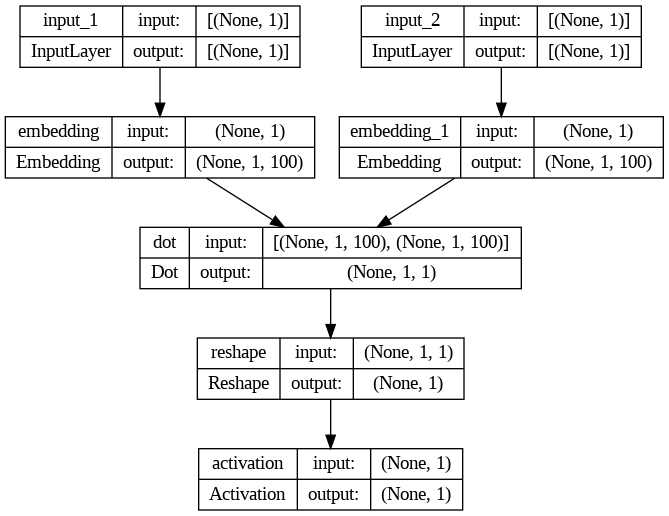

In [67]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
for epoch in range(100):
    loss = 0
    for _, elem in enumerate(training_dataset):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X, Y)
    print('Epoch:', epoch+1, 'Loss: ', loss)

In [ ]:
import gensim

In [ ]:
f = open('vectors.txt', 'w')
f.write('{} {} \n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
# print(vectors)
for word, i in tokenizer.word_index.items():
  f.write('{} {} \n'.format(word, ' '.join(map(str, list(vectors[i,:])))))
f.close()

In [ ]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['최저임금'])